# probabilistic Principle Component Analysis

In this notebook, we will see implementations of probabilistic Principle Component Analysis. 
We will work on both 
* maximum likelihood estimation using EM algorithm, and 
* Bayesian PCA

The contents of the notebook are arranged as follows:
* In Section 1, we will implement maximum likelihood estimation. 
* In Section 2, we will work on Bayesian approach.
* In Section 3, we compare the results of two approaches, focusing on how the latter approach can suppress effective degrees of freedom. 

In [1]:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from scipy.linalg import eigh

%matplotlib inline
mpl.rc("savefig",dpi=100)

## 1. Maximum Likelihood PCA

### 1.1 Model 

Let 
* $N \in \mathbb{N}$ be the number of data points, 
* $D \in \mathbb{N}$ be the dimension of data, and 
* $M \in \mathbb{N}$ be the dimension of the latent variable.

The model is defined by

$$
\begin{align}
    &{} p\left(X,Z \middle| \mu, W, \sigma^2 \right) = \prod_{n=0}^{N-1} p\left(x_n \middle| z_n, \mu, W, \sigma^2 \right)p(z_n) \\
    &{} p\left(z \right) := \mathcal{N}\left(z \middle| 0, I_M \right) \\ 
    &{} p\left(x \middle|z, \mu, W, \sigma^2 \right) := \mathcal{N}\left(x \middle| W z + \mu, \sigma^2 I_D \right) 
\end{align}
$$

where
* $X = (x_{n})_{ n \in \{ 0, 1, \dots, N-1 \}  }, \ x_{n}\in \mathbb{R}^D$ is the matrix that stands for data points, 
* $Z = (z_{n})_{ n \in \{ 0, 1, \dots, N-1 \} }, \ z_{n}\in \mathbb{R}^M$ is the matrix that stands for latent variables, and   
* $\mathcal{N}\left(\cdot \middle| \mu , \Sigma \right)$ is a gaussian probability density with mean $\mu$ and covariance matrix $\Sigma$.



### 1.2 Goal

Our goal here is to obtain $\mu, W, \sigma^2$ that maximizes the likelihood function

$$
\begin{align}
    p\left(X \middle| \mu, W, \sigma^2 \right) := \int  p\left(X,Z \middle| \mu, W, \sigma^2 \right) dZ, 
\end{align}
$$

whose form is shown in equation (12.43) of the book.

### 1.3 Theoretical result 
Although the maximization can be done analytically, here we take EM algorithm approach. 
The benefit of this approach is given in Section 12.2.2 of the book. 

First, maximization with respect to $\mu$ can be easily done, whose result is 

$$
\begin{align}
    \mu = \bar{x} := \frac{1}{N} \sum_{n=0}^{N-1}x_n. 
\end{align}
$$

In this section, we will henceforth fix $\mu$ to be this value.

In EM algorithm for probabilistic PCA, we update parameters $W$ and $\sigma^2$ as 

$$
\begin{align}
    &{} W_{new} = \left[ \sum_{n=0}^{N-1} (x_n - \bar{x}) \mathbb{E}_{old}[z_n]^T \right] 
        \left[ \sum_{n=0}^{N-1} \mathbb{E}_{old}[z_n z_{n}^{T}]  \right]^{-1} \\
    &{} \sigma^{2}_{new} = \frac{1}{ND}\sum_{n=0}^{N-1} 
        \left[ \| x_n - \bar{x} \|^2 - 2 \mathbb{E}_{old}\left[ z_n\right]^T W_{new}^{T} (x_n-\bar{x})
        + \mathrm{Tr}\left( \mathbb{E}_{old}\left[ z_n z_{n}^{T} \right] W_{new}^{T} W_{new} \right) \right] \\
    &{} \mathbb{E}_{old}\left[ z_n \right] := M_{old}^{-1} W_{old}^{T} \left( x_n - \bar{x} \right) \\
    &{} \mathbb{E}_{old}\left[ z_n z_{n}^{T} \right] := \sigma_{old}^{2} M_{old}^{-1} + 
        \mathbb{E}_{old}\left[ z_n \right] \mathbb{E}_{old}\left[ z_n \right]^T \\
    &{} M_{old} := W_{old}^{T} W_{old} + \sigma_{old}^{2} I_M
\end{align}
$$


### 1.4 Variables

* X : (N,D) array standing for observation data
* W : (D,M) array
* s2 : real number (positive)  standing for $\sigma^2$
* Ez : (N, M) array standing for $\mathbb{E}_{old}\left[z_n\right]$, Ez[n,i] = $\mathbb{E}_{old}\left[z_n\right]_i$
* sumEzz : (M,M) array standing for $\sum_{n=0}^{N-1} \mathbb{E}_{old}\left[z_n z_{n}^{T} \right]$, sumEzz[i,j] = $\sum_{n=0}^{N-1} \mathbb{E}_{old}\left[z_n z_{n}^{T} \right]_{i,j}$


### 1.5 Code

For sanity check, an analytical approach based on eigenvalue decomposition is also included.

In [2]:
class MLPCA:
    
    def __init__(self, D, M):
        self.D = D # the dimension of the data
        self.M = M # the dimension of the latent variable
        
    def load_dat(self, X):
        self.X = X # data matrix
        self.N = len(X) # the number of data
        self.x_mean = np.mean(self.X, axis=0) # the average of data matrix
        
    def init_params(self, W = None, s2 = None):
        self.W = np.eye(self.D)[:,:self.M] if (W is None) else W # probably there are better initializations 
        self.s2 = 1.0 if (s2 is None) else s2
    
    ############################################################
    # EM algorithm
    def Estep(self):
        Mmatinv = np.linalg.inv( (self.W).T @ self.W + self.s2*np.eye(self.M) ) # we only use inverse of the matrix M
        dX = X - np.reshape(self.x_mean,(1,self.D))
        self.Ez = dX @ self.W @ (Mmatinv.T)
        self.sumEzz = self.N*self.s2*Mmatinv + (self.Ez.T) @ self.Ez
        
    def Mstep(self):
        dX = X - np.reshape(self.x_mean,(1,self.D))
        self.W = ((dX.T) @ self.Ez) @  np.linalg.inv(self.sumEzz)
        self.s2 = ( np.linalg.norm(dX)**2 - 2*np.trace(self.Ez@ (self.W.T) @ (dX.T) ) + np.trace( self.sumEzz @ self.W.T @ self.W ) )  /(self.N*self.D)
    
    def fit(self, X, maxiter, W0=None, s20=None, tol=1e-4):
        self.load_dat(X)
        self.init_params(W=W0, s2=s20)
        
        for i in range(maxiter):
            Wold = self.W
            s2old = self.s2
            self.Estep()
            self.Mstep()
            err = np.linalg.norm(self.W - Wold)**2 + (self.s2 - s2old)**2
            if err < tol:
                break
        print(f"numiter = {i}")
    ############################################################
    # analytical solution
    
    def fit_analytical(self, X):
        self.load_dat(X)
        S = np.cov(X, rowvar=False) # calculate the data covariance matrix
        l, U = eigh(S) # eigenvalues and eigenvectors of the covariance matrix
        ind = np.argsort(l)[::-1][0:self.M] # sort the eigenvalues in decreasing order
        ltmp = l[ind]
        Utmp = U[:,ind]
        if self.D != self.M:
            self.s2 = 1/(self.D-self.M)*np.sum(np.sort(l)[::-1][self.M:])
        else:
            self.s2 = 0.0
        self.W = Utmp @ np.sqrt(np.diag(ltmp) - self.s2*np.eye(self.M))
    
    ############################################################
    
    def sample(self,num_sample):
        C = self.W @ (self.W.T) + self.s2*np.eye(self.D)
        return np.random.multivariate_normal(self.x_mean, C, num_sample)

### 1.6 Test

Here we check our code works using a simple two dimensional data.

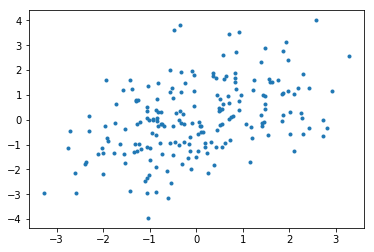

In [3]:
X = np.random.multivariate_normal(np.zeros(2), cov = np.array([[2,1],[1,2]]), size=200)
plt.plot(X[:,0],X[:,1],'.')
plt.show()

In [4]:
# function for plotting the result
def plot2dPCA(pca, X, ax, title=None):
    ax.plot(X[:,0],X[:,1],'.')
    xmin = np.min(X[:,0]); xmax = np.max(X[:,0])
    xave = np.mean(X,axis=0)[0]; yave = np.mean(X,axis=0)[1]
    slope = pca.W[1]/pca.W[0]
    ax.plot([xmin,xmax], [slope*(xmin-xave) + yave, slope*(xmax-xave)+yave  ])
    if not(title is None):
        ax.set_title(title)

# function for calculating the covariance matrix C of predictive distribution
# for checking whether the result of EM and closed form solution coincide
def calc_C(W, s2):
    return W @ W. T + s2*np.eye(np.shape(W)[0])

Below, we see how the principal component axis changes as we proceed the through EM algorithm. 

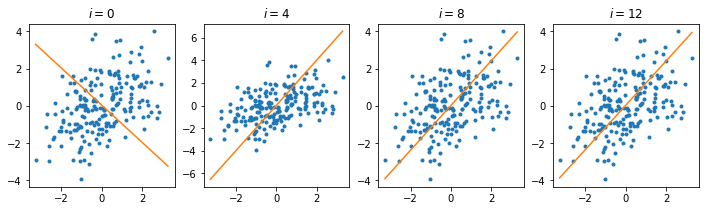

In [5]:
mlpca = MLPCA(D = 2, M = 1)
mlpca.load_dat(X)
mlpca.init_params(W = np.array([[1],[-1]]))
fig = plt.figure(figsize=(12,3))
for i in range(13):
    if i%4 == 0:
        ax = fig.add_subplot(1,4,i/4+1)
        plot2dPCA(mlpca, X, ax, title =f'$i={i}$')
    mlpca.Estep()
    mlpca.Mstep()
plt.show()

Let us compare the results of EM algorithm and the closed form solution by 
* comparing the covariance matrix $C$ of the predictive distribution, and 
* performing sampling using the learned model.

numiter = 15
0.000286380876828


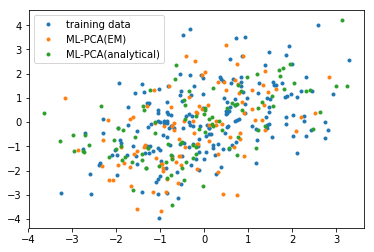

In [6]:
mlpca.fit(X,maxiter=100,tol=1e-6)
dat1 = mlpca.sample(100)
C1 = calc_C(W=mlpca.W, s2=mlpca.s2)
mlpca.fit_analytical(X)
dat2 = mlpca.sample(100)
C2 = calc_C(W=mlpca.W, s2=mlpca.s2)
print(np.linalg.norm(C1 - C2)**2)

plt.plot(X[:,0],X[:,1],'.',label='training data')
plt.plot(dat1[:,0], dat1[:,1],'.', label='ML-PCA(EM)')
plt.plot(dat2[:,0], dat2[:,1],'.', label='ML-PCA(analytical)')
plt.legend()
plt.show()

It can be seen that the results of two approaches coincide with each other.

Let us check the case with $M=2$.

numiter = 10
0.000334776547478


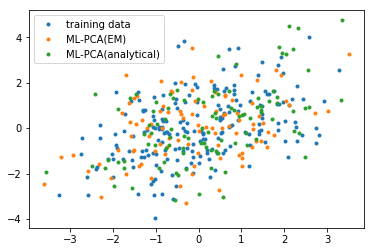

In [7]:
mlpca2 = MLPCA(D = 2, M = 2)

mlpca2.fit(X, maxiter=1000, tol=1e-6)
dat2_1 = mlpca2.sample(100)
C2_1 = calc_C(W=mlpca2.W, s2=mlpca2.s2)
mlpca2.fit_analytical(X)
dat2_2 = mlpca2.sample(100)
C2_2 = calc_C(W=mlpca2.W, s2=mlpca2.s2)
print(np.linalg.norm(C2_1 - C2_2)**2)

plt.plot(X[:,0],X[:,1],'.', label='training data')
plt.plot(dat2_1[:,0], dat2_1[:,1],'.',label='ML-PCA(EM)')
plt.plot(dat2_2[:,0], dat2_2[:,1],'.',label='ML-PCA(analytical)')
plt.legend()
plt.show()

## 2 Bayesian PCA

### 2.1 Model 

Let 
* $N \in \mathbb{N}$ be the number of data points, 
* $D \in \mathbb{N}$ be the dimension of data, and 
* $M \in \mathbb{N}$ be the dimension of the latent variable.

The model is defined by

$$
\begin{align}
    & p\left(X,Z \middle| \mu, W, \sigma^2 \right) = \prod_{n=0}^{N-1} p\left(x_n \middle| z_n, \mu, W, \sigma^2 \right)p(z_n) \\
    & p \left(W \middle|\alpha \right) = \prod_{i=0}^{M-1} \left[ \left( \frac{\alpha_i}{2\pi}\right)^{D/2} \exp \left( - \frac{1}{2} \alpha_i w_{i}^{T} w_i \right) \right] \\
    & p\left(z \right) := \mathcal{N}\left(z \middle| 0, I_M \right) \\ 
    & p\left(x \middle|z, \mu, W, \sigma^2 \right) := \mathcal{N}\left(x \middle| W z + \mu, \sigma^2 I_D \right) 
\end{align}
$$

where
* $X = (x_{n})_{ n \in \{ 0, 1, \dots, N-1 \}  }, \ x_{n}\in \mathbb{R}^D$ is the matrix that stands for data points, 
* $Z = (z_{n})_{ n \in \{ 0, 1, \dots, N-1 \} }, \ z_{n}\in \mathbb{R}^M$ is the matrix that stands for latent variables, 
* $\mathcal{N}\left(\cdot \middle| \mu , \Sigma \right)$ is a gaussian probability density with mean $\mu$ and covariance matrix $\Sigma$, and 
* $w_i$ is the $i$th column vector of matrix $W$.


### 2.2 Goal

Our goal here is to obtain $\mu, \alpha, \sigma^2$ that maximizes the marginal likelihood function

$$
\begin{align}
    p\left(X \middle| \alpha, \mu, \sigma^2 \right) &:= \int  p\left(X,Z \middle| \mu, W, \sigma^2 \right) p(W|\alpha) dW dZ \\
    &= \int  p\left(X \middle| \mu, W, \sigma^2 \right) p(W|\alpha) dW 
\end{align}
$$

### 2.3 Theoretical result 

The maximization with respect to $\mu$ can be easily done, whose result is 
\begin{align}
    \mu = \bar{x} := \frac{1}{N} \sum_{n=0}^{N-1}x_n. 
\end{align}
In this section, we will henceforth fix $\mu$ to be this value.

By applying Laplace approximation to the integral above, and neglecting the factor coming from hessian (Note : I am not sure under what kind of condition the latter approximation can be justified. ), the problem is reduced to obtain $W, \alpha, \sigma^2$ that maximize

$$
\begin{align}
    &{} \frac{D}{2} \sum_{i=1}^{M} \log \alpha_i - E(W, \sigma^2, \alpha), \\
    &{} E(W, \sigma^2, \alpha) := - \log p\left( X \middle| W, \mu, \sigma^2 \right)
        + \frac{1}{2} \sum_{i=0}^{M-1} \alpha_i \| w_i \|^2
\end{align}
$$

The maximization is done iteratively: 
* for $W$ and $\sigma^2$, a variation of EM algorithm for MAP estimation is utilized, and 
* for $\alpha$, re-estimation equation (12.62) is utilied.

(Note : As far as I understand, the process is not an EM algorithm, because it contains the re-estimation of $\alpha$. Below, I use equations shown in the book, but I have not understood theoretical justifications of this iterative optimization process. )

$$
\begin{align}
    & W_{new} = \left[ \sum_{n=0}^{N-1} (x_n - \bar{x}) \mathbb{E}_{old}[z_n]^T \right] 
        \left[ \sum_{n=0}^{N-1} \mathbb{E}_{old}[z_n z_{n}^{T}]  + \sigma_{old}^{2} A \right]^{-1} \\
    & A = \mathrm{diag}\left( \alpha_{i, old} \right) \\
    & \sigma^{2}_{new} = \frac{1}{ND}\sum_{n=0}^{N-1} 
        \left[ \| x_n - \bar{x} \|^2 - 2 \mathbb{E}_{old}\left[ z_n\right]^T W_{new}^{T} (x_n-\bar{x})
        + \mathrm{Tr}\left( \mathbb{E}_{old}\left[ z_n z_{n}^{T} \right] W_{new}^{T} W_{new} \right) \right] \\
    & \mathbb{E}_{old}\left[ z_n \right] := M_{old}^{-1} W_{old}^{T} \left( x_n - \bar{x} \right) \\
    & \mathbb{E}_{old}\left[ z_n z_{n}^{T} \right] := \sigma_{old}^{2} M_{old}^{-1} + 
        \mathbb{E}_{old}\left[ z_n \right] \mathbb{E}_{old}\left[ z_n \right]^T \\
    & M_{old} := W_{old}^{T} W_{old} + \sigma_{old}^{2} I_M \\
    & \alpha_{i,new} = \frac{D}{\|w_{i,new}\|^2}
\end{align}
$$


### 2.4 Variables

* X : (N,D) array standing for observation data
* W : (D,M) array
* s2 : real number (positive)  standing for $\sigma^2$
* al : (M,) array corresponding to $\alpha$
* Ez : (N, M) array standing for $\mathbb{E}_{old}\left[z_n\right]$, Ez[n,i] = $\mathbb{E}_{old}\left[z_n\right]_i$
* sumEzz : (M,M) array standing for $\sum_{n=0}^{N-1} \mathbb{E}_{old}\left[z_n z_{n}^{T} \right]$, sumEzz[i,j] = $\sum_{n=0}^{N-1} \mathbb{E}_{old}\left[z_n z_{n}^{T} \right]_{i,j}$


### 2.5 Code

It can be easily seen that the code for Bayesian PCA can be easily obtained by slightly modifying the code for EM algorithm ML-PCA. 

In [8]:
class BPCA(MLPCA):
    
    # alpha is added
    def init_params(self, W = None, s2 = None, al = None):
        self.W = np.eye(self.D)[:,:self.M] if (W is None) else W
        self.s2 = 1.0 if (s2 is None) else s2
        self.al = np.random.random(self.M)+1 if (al is None) else al
        
    # update rule for W is changed
    def Mstep(self):
        dX = X - np.reshape(self.x_mean,(1,self.D))
        self.W = ((dX.T) @ self.Ez) @  np.linalg.inv(self.sumEzz + self.s2*np.diag(self.al))
        self.s2 = ( np.linalg.norm(dX)**2 - 2*np.trace(self.Ez@ (self.W.T) @ (dX.T) ) + np.trace( self.sumEzz @ self.W.T @ self.W ) )  /(self.N*self.D)

    def calc_alpha(self):
        wnorms = np.linalg.norm(self.W, axis=0)**2
        for i in range(self.M):
            self.al[i] = self.D/wnorms[i] if (wnorms[i] !=0) else np.inf
    
    def fit(self, X, maxiter, W0=None, s20=None, tol=1e-4):
        self.load_dat(X)
        self.init_params(W=W0, s2=s20)
        
        for i in range(maxiter):
            Wold = self.W
            s2old = self.s2
            self.Estep()
            self.Mstep()
            self.calc_alpha()
            # we expect that alpha for irrelevant degrees of freedom grow to infinity, and hence excludes them from the condition of convergence
            err = np.linalg.norm(self.W - Wold)**2 + (self.s2 - s2old)**2
            if err < tol:
                break
        print(f"numiter = {i}")


### 2.6 Test

Again, we check the code by a simple two-dimensional example.

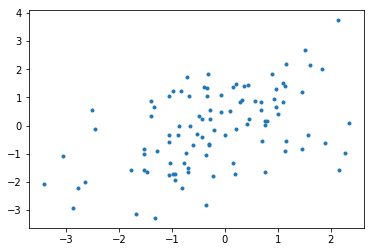

In [9]:
X = np.random.multivariate_normal(np.zeros(2), cov = np.array([[2,1],[1,2]]), size=100)
plt.plot(X[:,0],X[:,1],'.')
plt.show()

Shown below are the results of iterative optimization.

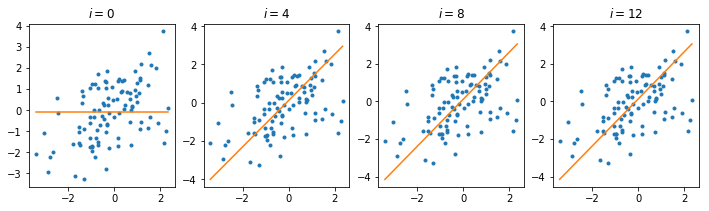

In [10]:
bpca = BPCA(D = 2, M = 1)
bpca.load_dat(X)
bpca.init_params()
fig = plt.figure(figsize=(12,3))
for i in range(13):
    if i%4 == 0:
        ax = fig.add_subplot(1,4,i/4+1)
        plot2dPCA(bpca, X, ax, title =f'$i={i}$')
    bpca.Estep()
    bpca.Mstep()
    bpca.calc_alpha()
plt.show()

The sampling can be performed as in the previous section. 

(Note : the sampling performed here is not the sampling from the fully Bayesian model, but with fixed $W$, whose value is determined from MAP estimation with $\alpha$ determined from the maximization of marginal likelihood.)

numiter = 16


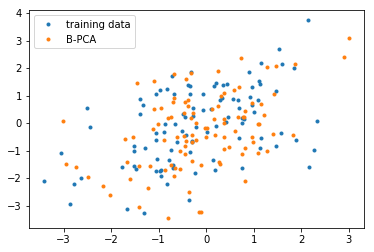

In [11]:
bpca.fit(X,maxiter=200,tol=1e-6)
dat = bpca.sample(100)
plt.plot(X[:,0],X[:,1],'.', label='training data')
plt.plot(dat[:,0], dat[:,1],'.', label='B-PCA')
plt.legend()
plt.show()

Let us take a look at the case with $M=2$.

numiter = 52
alpha=[        inf  1.27467794]


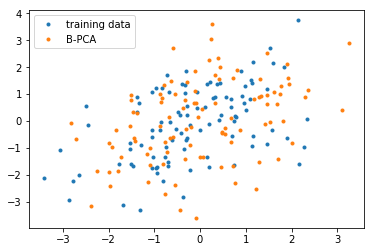

In [12]:
bpca2 = BPCA(D = 2, M = 2)
bpca2.fit(X,maxiter=200,tol=1e-6)
print(f'alpha={bpca2.al}')
dat = bpca2.sample(100)
plt.plot(X[:,0],X[:,1], '.', label='training data')
plt.plot(dat[:,0], dat[:,1], '.', label='B-PCA')
plt.legend()
plt.show()

Here, we have similar result with $M=1$ case, with the irrelevant degree of freedom being suppressed (it can be seen from the value of alpha).

## 3. Comparison

In this section, we briefly compare the difference between the maximum likelihood approach and the Bayesian approach, focusing on the effective degrees of freedom. 

Although we have seen the property in the previous sections for two-dimensional case, here we use larger example, and visualize the difference more clearly. 

### 3.1 Data

Following the textbook, we use 10 dimensional data with the true dimension of the latent variable being 3. 

We generate such data by 
* first sampling $z \in \mathbb{R}^3$ from zero-mean, unit covariance normal distribution, 
* transform $z$ by $Wz + \mu$, where $W$ and $\mu$ are randomly generated, and
* add isotropic gaussian noises $\varepsilon$ to obtain $x = Wz + \mu + \varepsilon$

In [13]:
N = 100
D = 10
dim_latent = 3
Z = np.random.multivariate_normal(np.zeros(dim_latent), np.eye(dim_latent), size=N)
W = np.random.random((D,dim_latent))
mu = np.random.random(D)
s2 = 0.1
X = Z @ (W.T) + np.reshape(mu,(1,D)) + np.random.multivariate_normal(np.zeros(D), cov=s2*np.eye(D), size=100)

### 3.2 Calculation

numiter = 74
numiter = 403


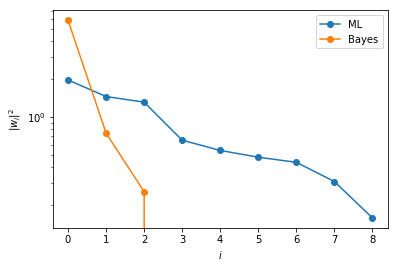

In [14]:
mlpca = MLPCA(D = D, M = 9)
mlpca.fit(X, maxiter = 2000, tol = 1e-5)
bpca = BPCA(D = D, M = 9)
bpca.fit(X, maxiter = 2000, tol = 1e-5)

bWsize = np.linalg.norm(bpca.W, axis = 0)**2
mlWsize = np.linalg.norm(mlpca.W, axis = 0)**2

plt.plot(np.sort(mlWsize)[::-1], 'o-', label="ML")
plt.plot(np.sort(bWsize)[::-1], 'o-', label="Bayes")
plt.yscale('log')
plt.xlabel(r'$i$')
plt.ylabel(r'$\|w_i\|^2$')
plt.legend()
plt.show()

We can clearly see taht the Bayesian approach suppresses redundant degreesof freedom.